In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
from transformers import EarlyStoppingCallback
import torch
from torch.utils.data import DataLoader
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Sat Jul 13 10:14:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
df = pd.read_csv('nli_aug.csv')

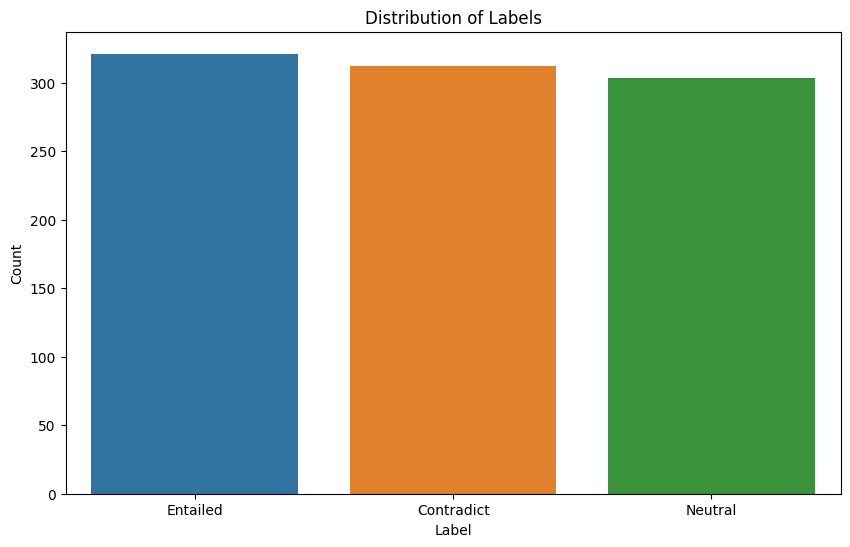

In [ ]:
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [ ]:
legal_act_counts = df['legal_act'].value_counts()
print("\nCount of each legal act in the dataset:")
print(legal_act_counts)



Count of each legal act in the dataset:
privacy                489
tcpa                   222
consumer_protection    186
wage                    39
Name: legal_act, dtype: int64


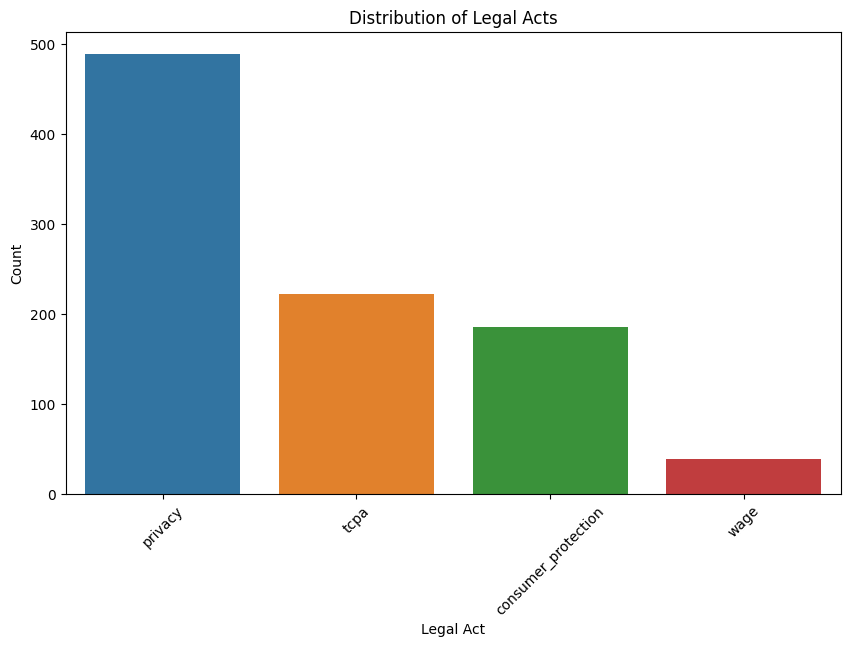

In [ ]:
# Plot the distribution of legal acts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='legal_act', order=df['legal_act'].value_counts().index)
plt.title('Distribution of Legal Acts')
plt.xlabel('Legal Act')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Initialize the tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

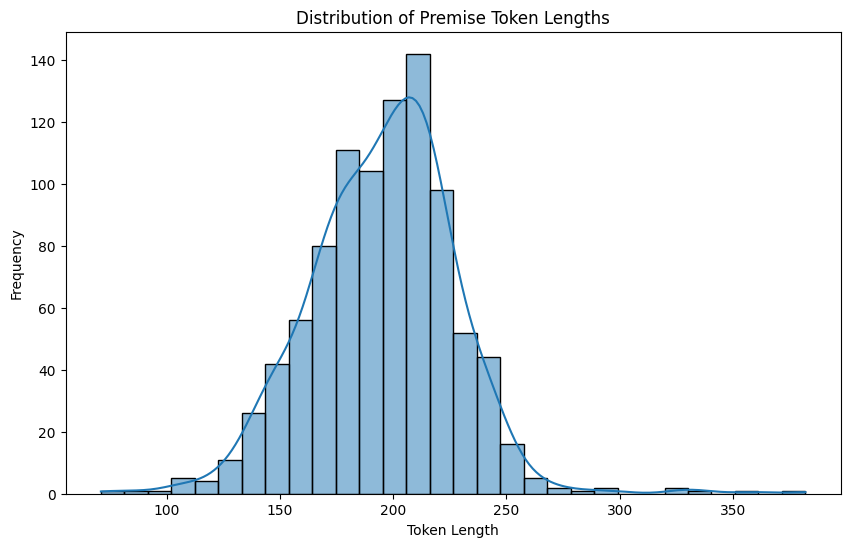

In [ ]:
# Tokenize the premises and hypotheses
df['premise_tokens'] = df['premise'].apply(lambda x: tokenizer.encode(x, truncation=True, padding=True))
df['hypothesis_tokens'] = df['hypothesis'].apply(lambda x: tokenizer.encode(x, truncation=True, padding=True))

# Calculate the token lengths
df['premise_token_length'] = df['premise_tokens'].apply(len)
df['hypothesis_token_length'] = df['hypothesis_tokens'].apply(len)
df['concat_token_length'] = df['premise_token_length'] + df['hypothesis_token_length']

# Plot the distribution of token lengths for premises
plt.figure(figsize=(10, 6))
sns.histplot(df['premise_token_length'], bins=30, kde=True)
plt.title('Distribution of Premise Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

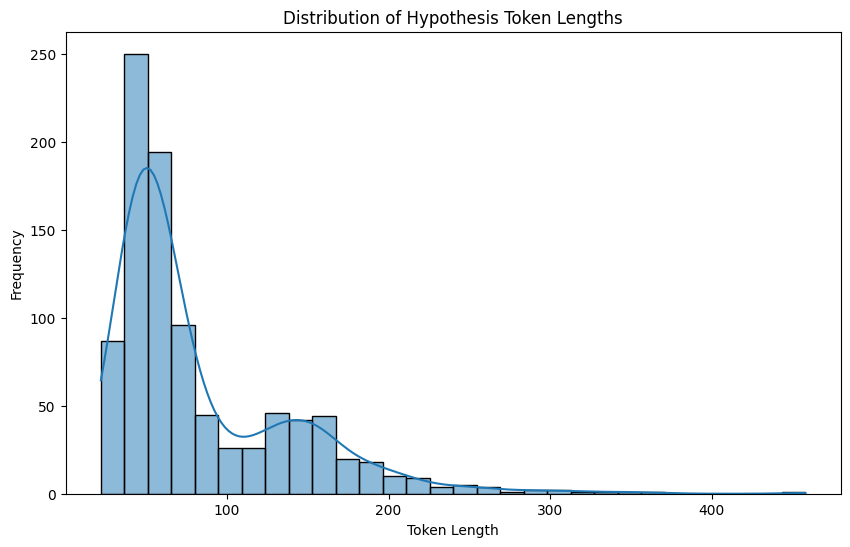

In [ ]:

# Plot the distribution of token lengths for hypotheses
plt.figure(figsize=(10, 6))
sns.histplot(df['hypothesis_token_length'], bins=30, kde=True)
plt.title('Distribution of Hypothesis Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()


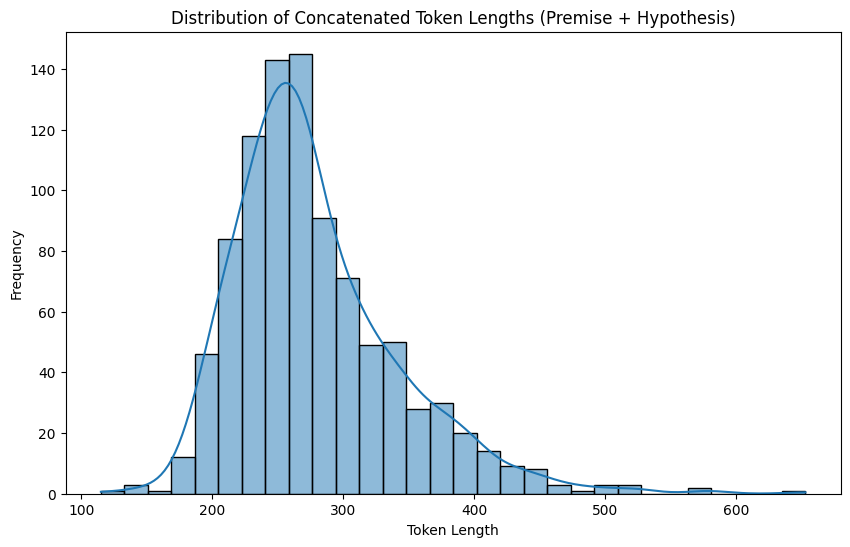

In [ ]:
# Plot the distribution of concatenated token lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['concat_token_length'], bins=30, kde=True)
plt.title('Distribution of Concatenated Token Lengths (Premise + Hypothesis)')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()


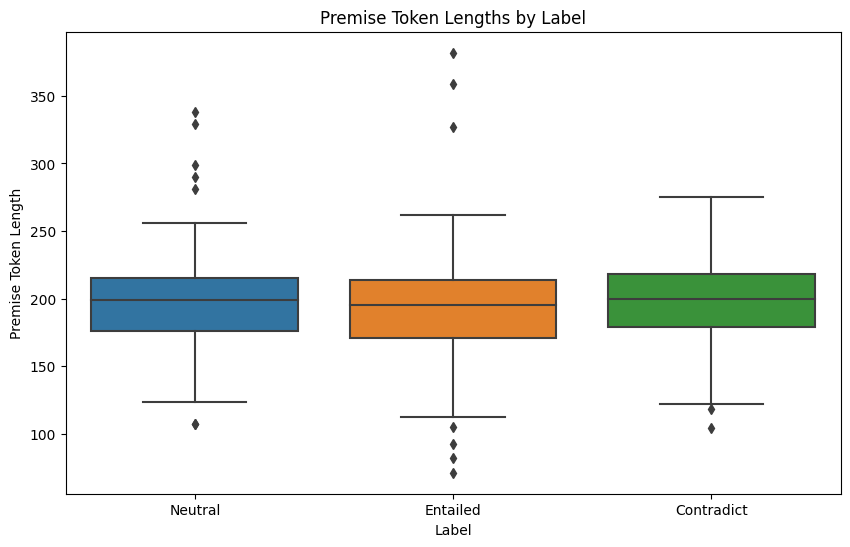

In [ ]:

# Explore the relationship between labels and token lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='premise_token_length')
plt.title('Premise Token Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Premise Token Length')
plt.show()

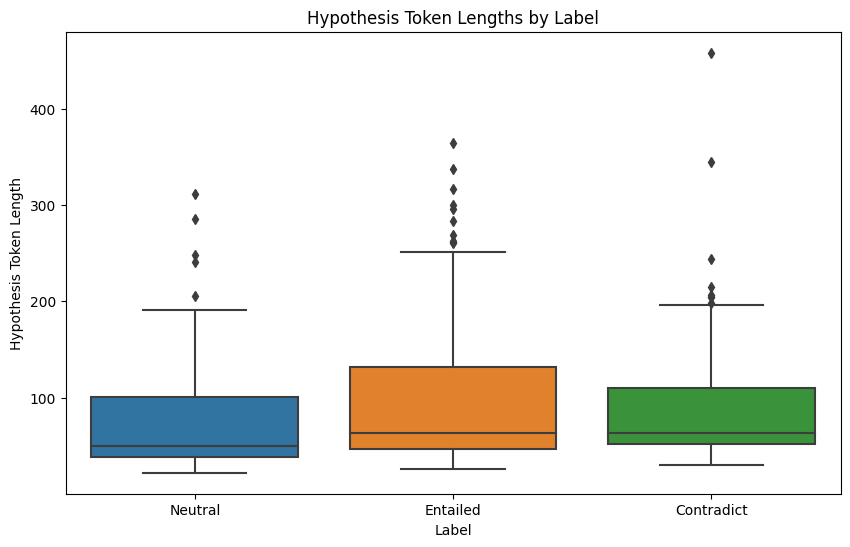

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='hypothesis_token_length')
plt.title('Hypothesis Token Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Hypothesis Token Length')
plt.show()


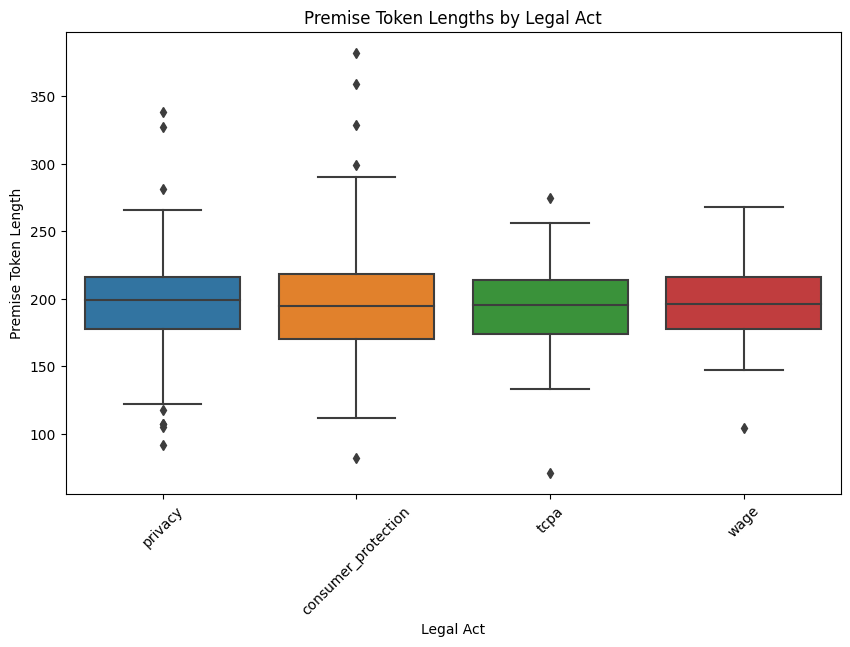

In [ ]:
# Explore the relationship between legal acts and token lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='legal_act', y='premise_token_length')
plt.title('Premise Token Lengths by Legal Act')
plt.xlabel('Legal Act')
plt.ylabel('Premise Token Length')
plt.xticks(rotation=45)
plt.show()

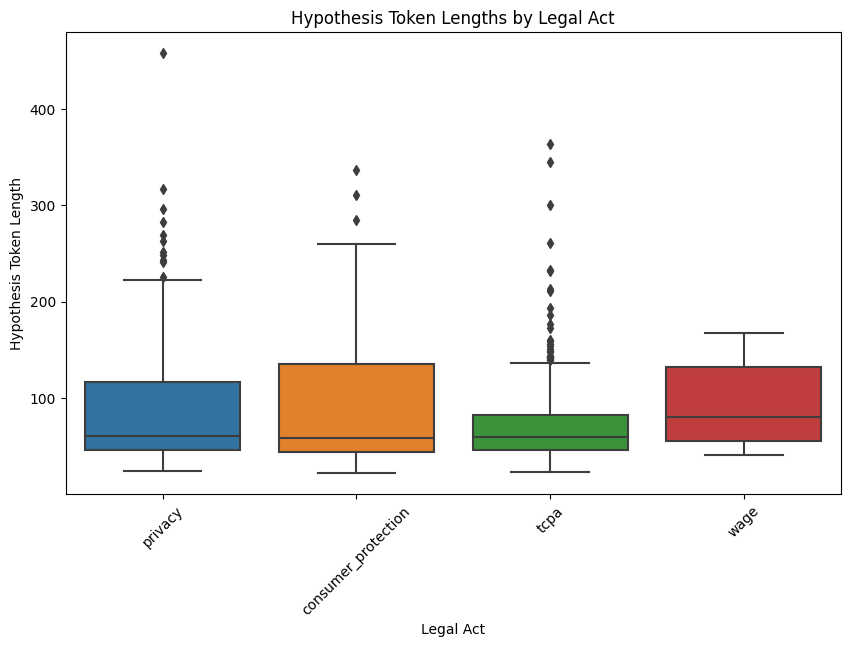

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='legal_act', y='hypothesis_token_length')
plt.title('Hypothesis Token Lengths by Legal Act')
plt.xlabel('Legal Act')
plt.ylabel('Hypothesis Token Length')
plt.xticks(rotation=45)
plt.show()


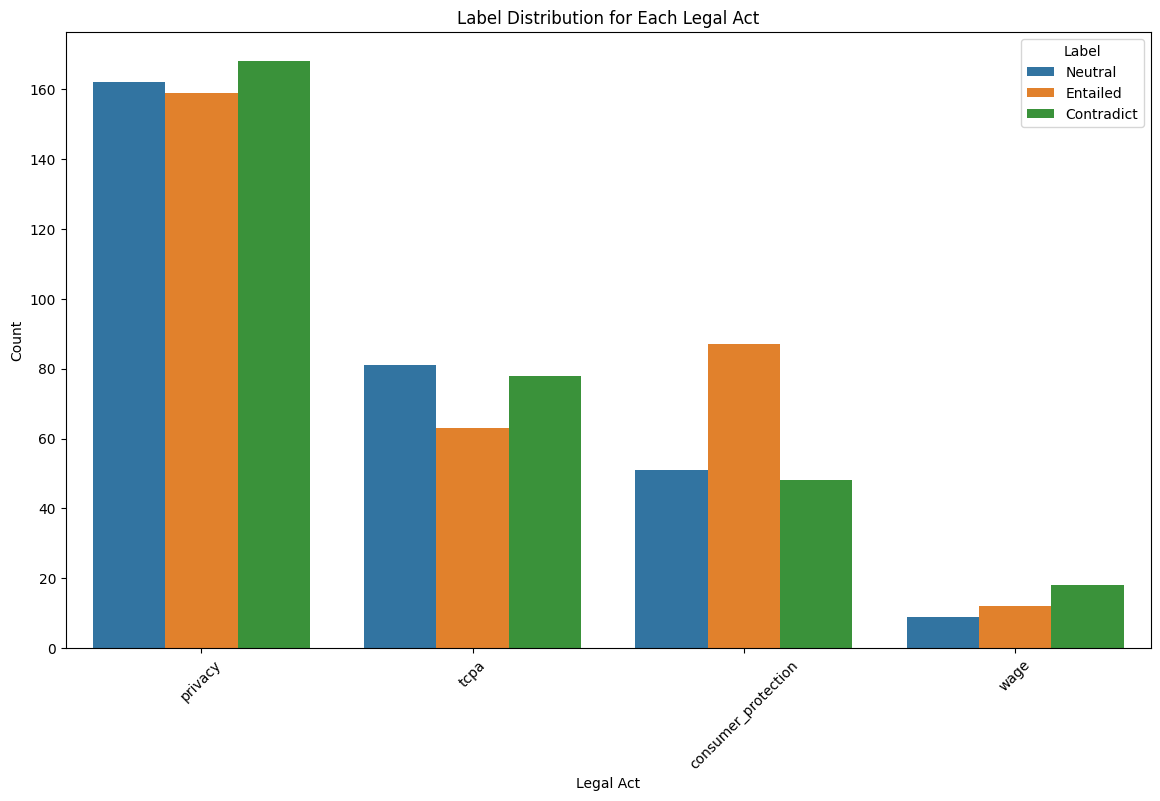

In [ ]:

# Label Distribution for Each Legal Act
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='legal_act', hue='label', order=df['legal_act'].value_counts().index)
plt.title('Label Distribution for Each Legal Act')
plt.xlabel('Legal Act')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()

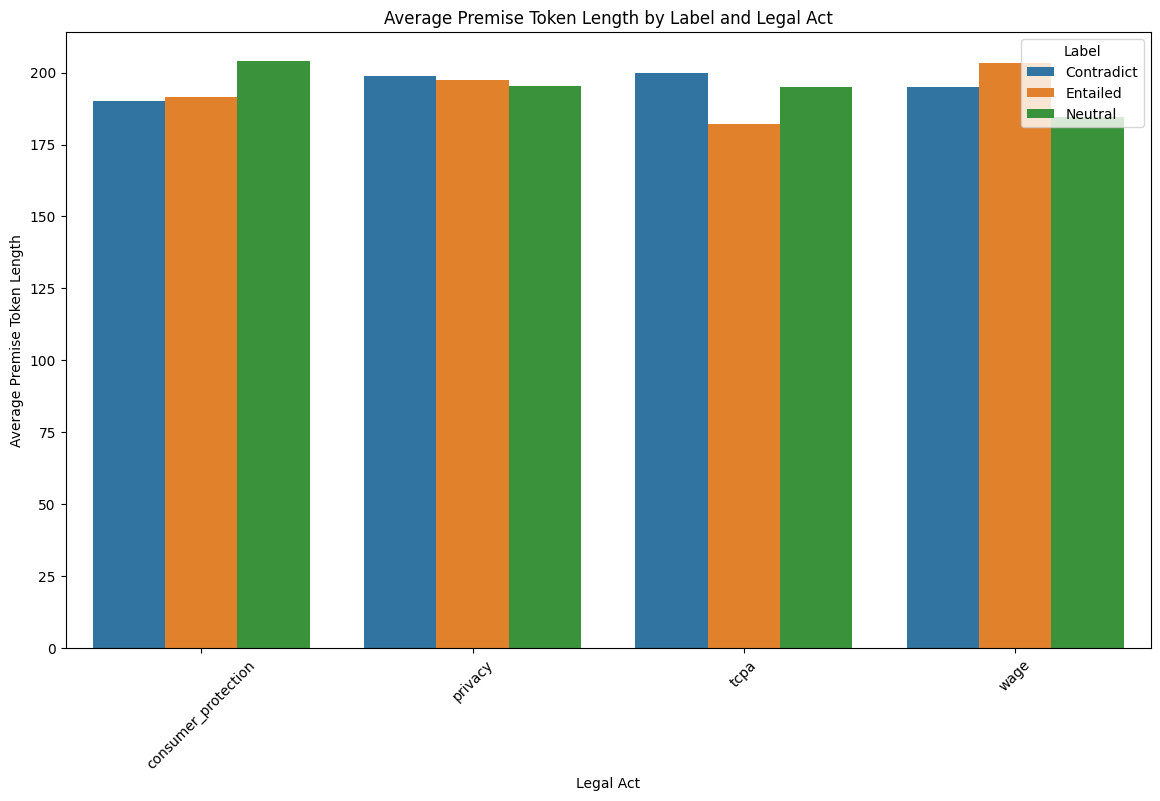

In [ ]:
# Average Token Length by Label and Legal Act
avg_premise_length = df.groupby(['legal_act', 'label'])['premise_token_length'].mean().reset_index()
avg_hypothesis_length = df.groupby(['legal_act', 'label'])['hypothesis_token_length'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=avg_premise_length, x='legal_act', y='premise_token_length', hue='label')
plt.title('Average Premise Token Length by Label and Legal Act')
plt.xlabel('Legal Act')
plt.ylabel('Average Premise Token Length')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()

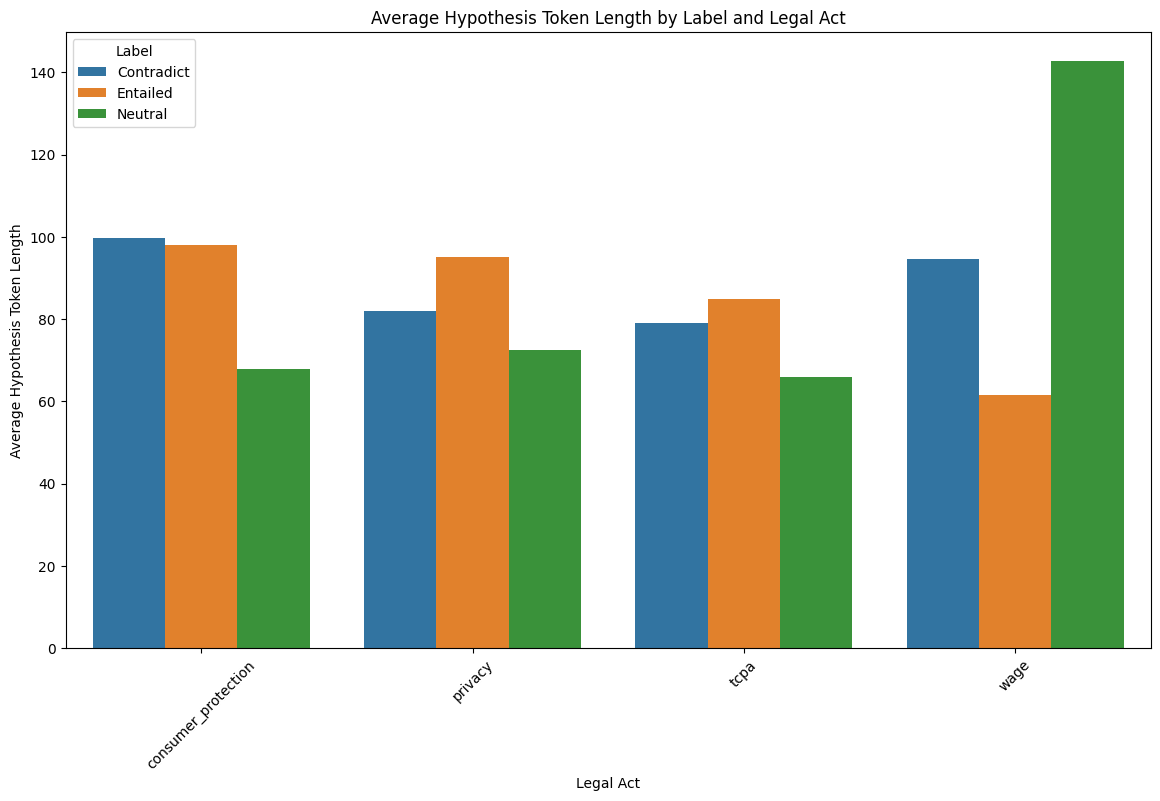

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_hypothesis_length, x='legal_act', y='hypothesis_token_length', hue='label')
plt.title('Average Hypothesis Token Length by Label and Legal Act')
plt.xlabel('Legal Act')
plt.ylabel('Average Hypothesis Token Length')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()


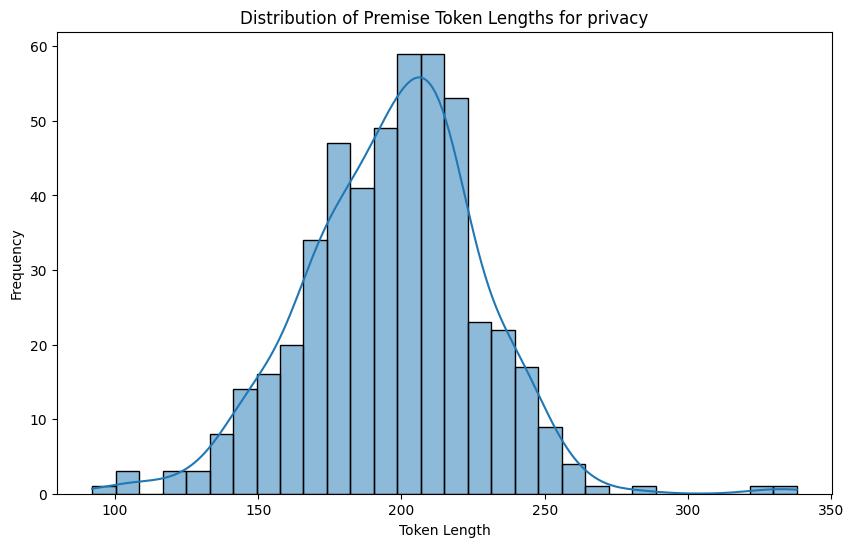

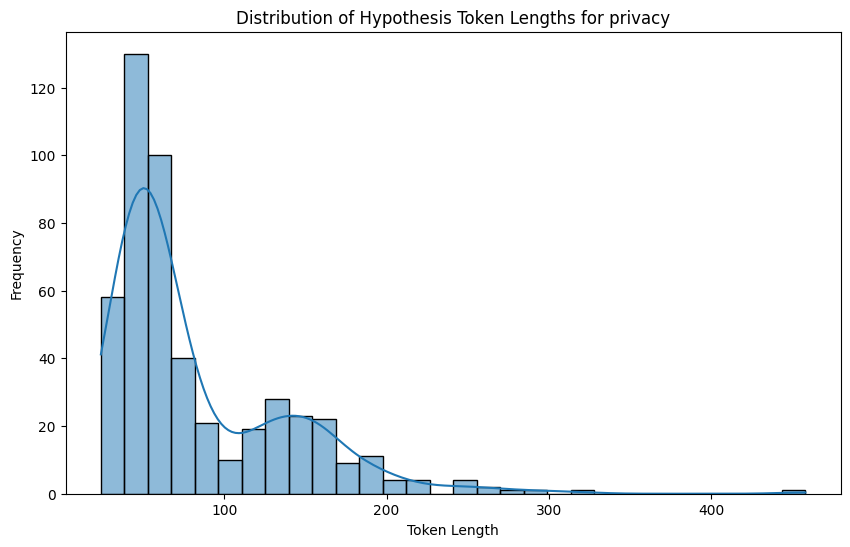

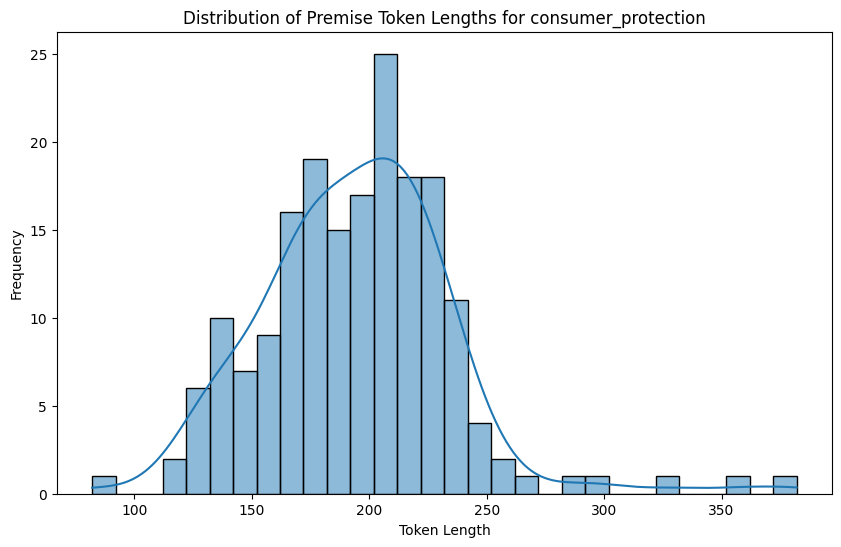

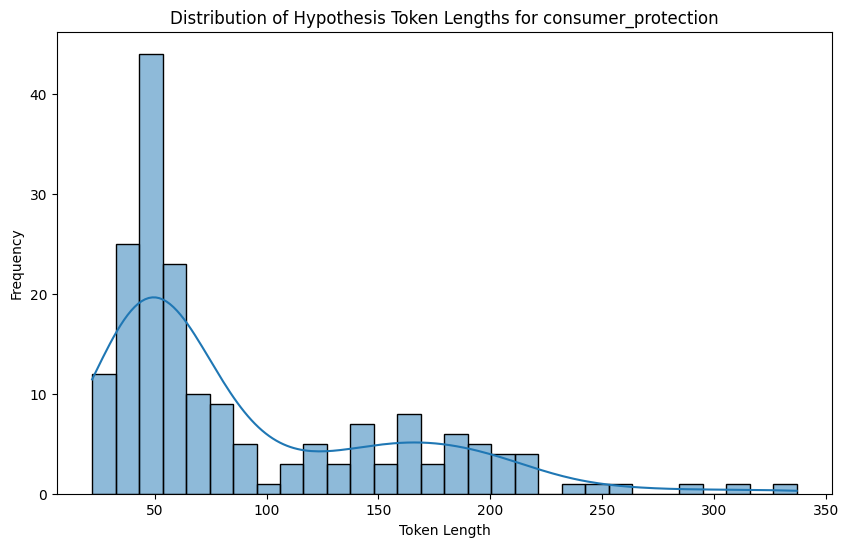

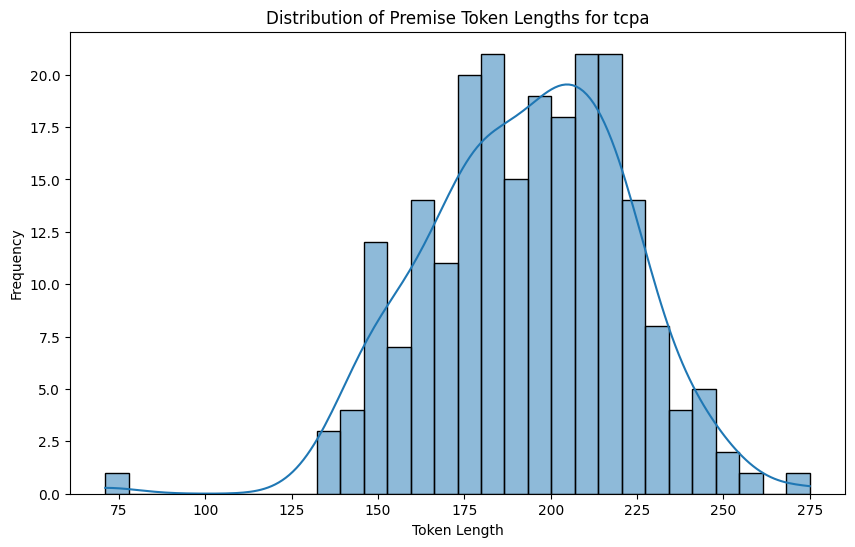

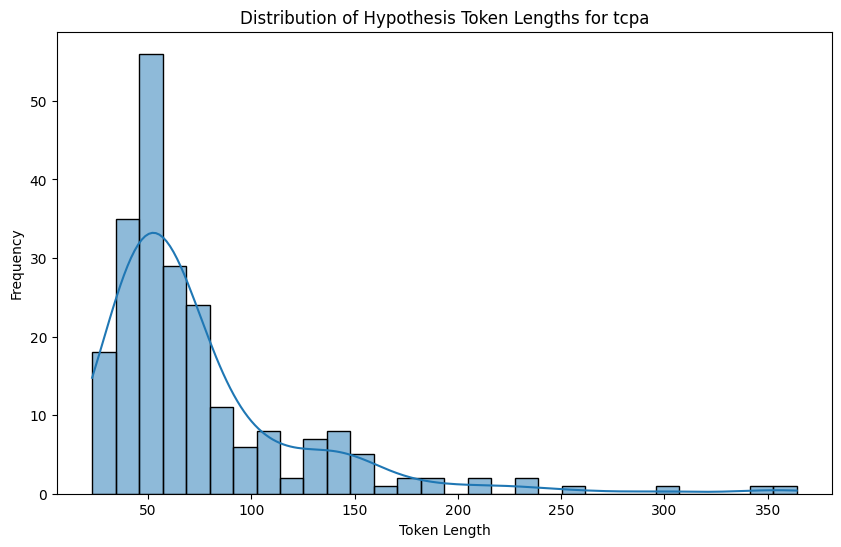

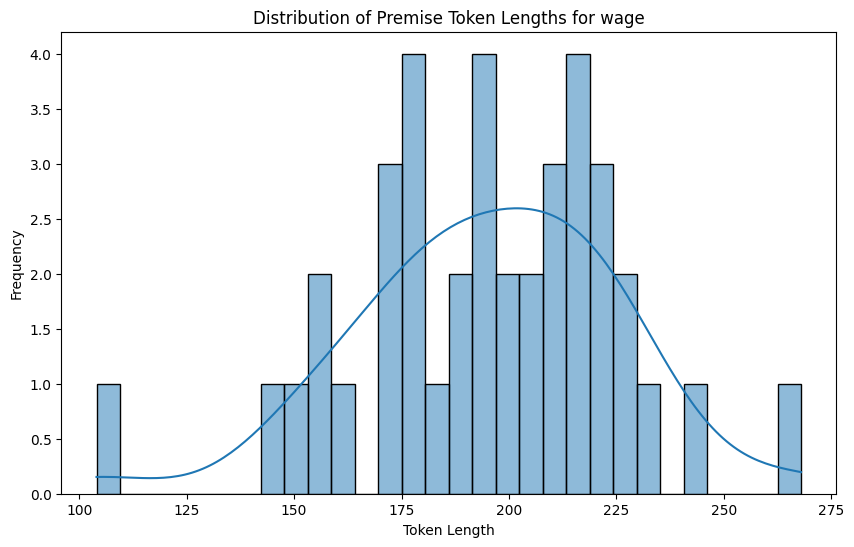

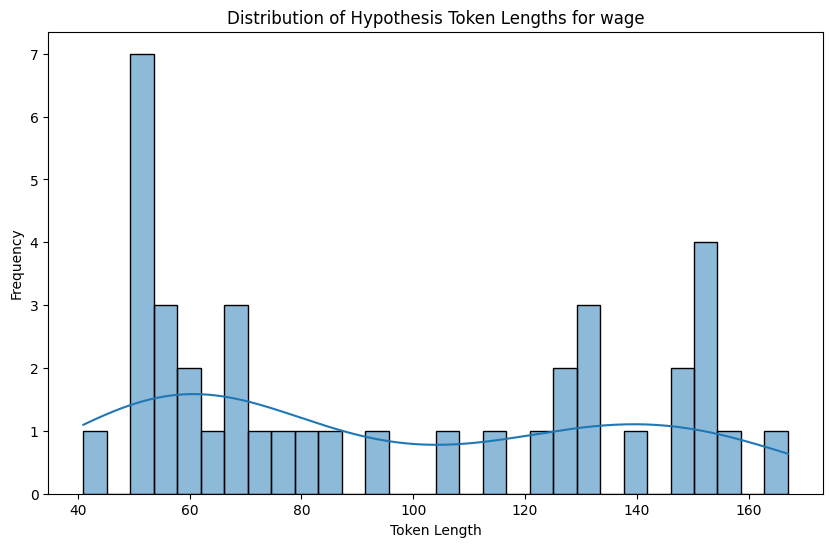

In [ ]:
# Token Length Distributions by Legal Act
legal_acts = df['legal_act'].unique()
for legal_act in legal_acts:
    subset = df[df['legal_act'] == legal_act]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(subset['premise_token_length'], bins=30, kde=True)
    plt.title(f'Distribution of Premise Token Lengths for {legal_act}')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(subset['hypothesis_token_length'], bins=30, kde=True)
    plt.title(f'Distribution of Hypothesis Token Lengths for {legal_act}')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()

#UMAP 

In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaTokenizer, RobertaModel

import umap
import seaborn as sns

In [ ]:
import umap.umap_ as umap


In [ ]:
df = pd.read_csv('/root/darrow-data-lake/csv/nli_aug.csv')

In [ ]:
df = df[df['augmentation']!='translation']

In [ ]:
# Define label mapping
label_map = {'Neutral': 0, 'Entailed': 1, 'Contradict': 2}

# Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()



# Get embeddings for the premise and hypothesis
df['premise_embeddings'] = df['premise'].apply(lambda x: get_embeddings([x]))
df['hypothesis_embeddings'] = df['hypothesis'].apply(lambda x: get_embeddings([x]))

# Combine premise and hypothesis embeddings
df['combined_embeddings'] = df.apply(lambda row: (row['premise_embeddings'] + row['hypothesis_embeddings']) / 2, axis=1)

/root/.ipykernel/2505/command-3246634641970750-1381711332:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['premise_embeddings'] = df['premise'].apply(lambda x: get_embeddings([x]))
/root/.ipykernel/2505/command-3246634641970750-1381711332:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hypothesis_embeddings'] = df['hypothesis'].apply(lambda x: get_embeddings([x]))
/root/.ipykernel/2505/command-3246634641970750-1381711332:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [ ]:

# Extract combined embeddings and ensure proper shape
embeddings = np.vstack(df['combined_embeddings'].values)

# Convert labels and legal_act to numerical format if they are not already
label_map = {'Neutral': 0, 'Entailed': 1, 'Contradict': 2}
df['label_num'] = df['label'].map(label_map)

legal_act_map = {act: idx for idx, act in enumerate(df['legal_act'].unique())}
df['legal_act_num'] = df['legal_act'].map(legal_act_map)

# Fit supervised UMAP for labels
reducer_label = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', target_metric='categorical')
umap_embeddings_label = reducer_label.fit_transform(embeddings, df['label_num'])

# Fit supervised UMAP for legal acts
reducer_legal_act = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', target_metric='categorical')
umap_embeddings_legal_act = reducer_legal_act.fit_transform(embeddings, df['legal_act_num'])

# Add UMAP embeddings to the DataFrame
df['umap_x_label'] = umap_embeddings_label[:, 0]
df['umap_y_label'] = umap_embeddings_label[:, 1]

df['umap_x_legal_act'] = umap_embeddings_legal_act[:, 0]
df['umap_y_legal_act'] = umap_embeddings_legal_act[:, 1]


/root/.ipykernel/2505/command-3246634641970770-4133350707:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_num'] = df['label'].map(label_map)
/root/.ipykernel/2505/command-3246634641970770-4133350707:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['legal_act_num'] = df['legal_act'].map(legal_act_map)
/root/.ipykernel/2505/command-3246634641970770-4133350707:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

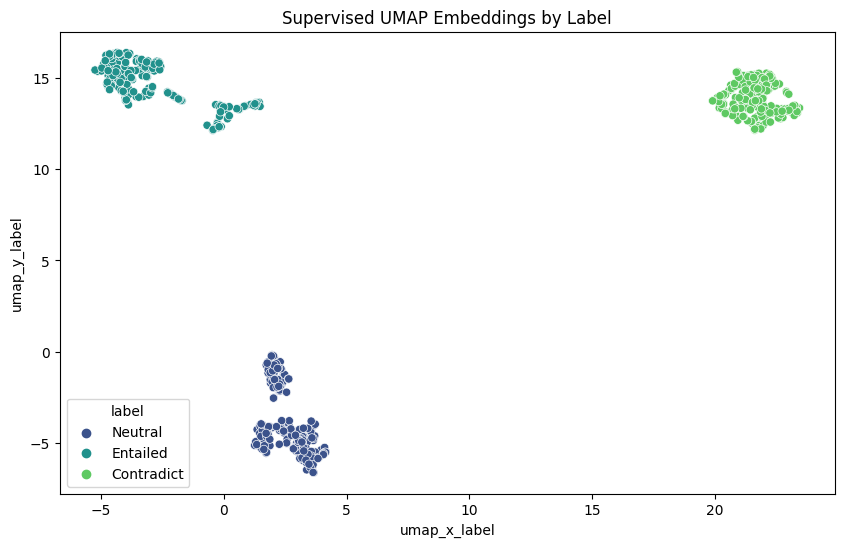

In [ ]:
# Plot UMAP embeddings by label
plt.figure(figsize=(10, 6))
sns.scatterplot(x='umap_x_label', y='umap_y_label', hue='label', data=df, palette='viridis')
plt.title('Supervised UMAP Embeddings by Label')
plt.show()


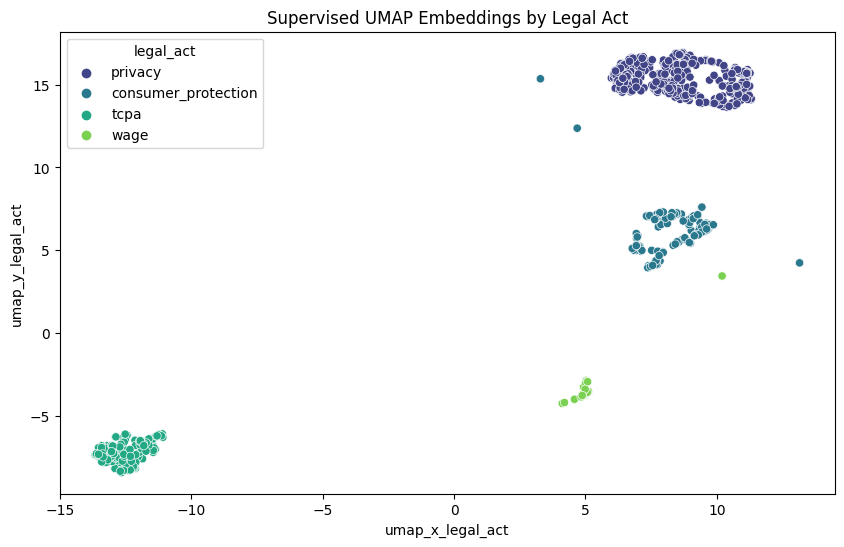

In [ ]:
# Plot UMAP embeddings by legal act
plt.figure(figsize=(10, 6))
sns.scatterplot(x='umap_x_legal_act', y='umap_y_legal_act', hue='legal_act', data=df, palette='viridis')
plt.title('Supervised UMAP Embeddings by Legal Act')
plt.show()

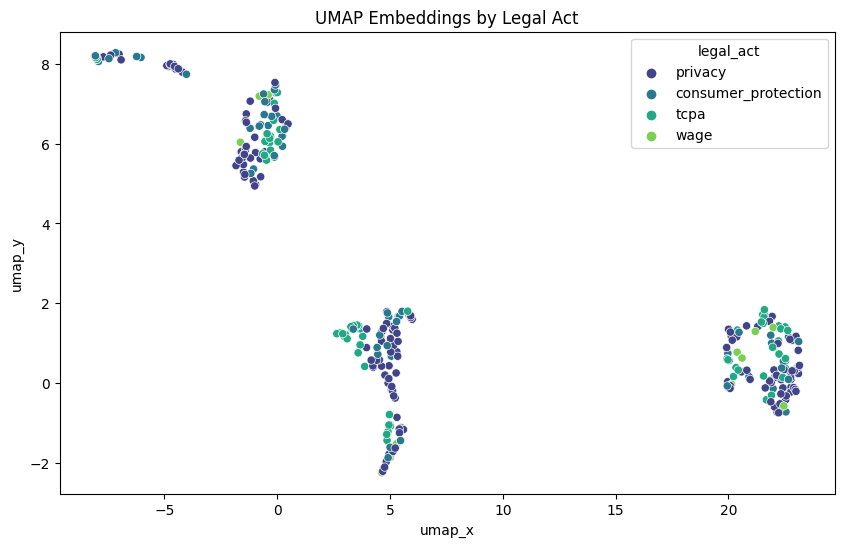